# From R-corr. to HAL QCD pot. and eigenfunc.

This notebook is a set of sample codes for the HAL QCD method, and finite volume eigensolver from the R-correlator.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import pickle

In [4]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit
m_red = 0.5 * mxi # reduced mass

In [5]:
from scipy.sparse.linalg import LinearOperator

In [6]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import R-corr.

We consider $L = 48$ and potential at $t=13$ (R-corr. t = 12, 13, 14).

In [7]:
ls ../data/Rcorr

Rcorr_xixi_1s0_L40_t010_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t010_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t011_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t011_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t012_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t012_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t013_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t013_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t014_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t014_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t015_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t015_wall_20jkbins.pkl
Rcorr_xixi_1s0_L40_t016_exp_20jkbins.pkl
Rcorr_xixi_1s0_L40_t016_wall_20jkbins.pkl
Rcorr_xixi_1s0_L48_t010_exp_20jkbins.pkl
Rcorr_xixi_1s0_L48_t010_wall_20jkbins.pkl
Rcorr_xixi_1s0_L48_t011_exp_20jkbins.pkl
Rcorr_xixi_1s0_L48_t011_wall_20jkbins.pkl
Rcorr_xixi_1s0_L48_t012_exp_20jkbins.pkl
Rcorr_xixi_1s0_L48_t012_wall_20jkbins.pkl
Rcorr_xixi_1s0_L48_t013_exp_20jkbins.pkl
Rcorr_xixi_1s0_L48_t013_wall_20jkbins.pkl
Rcorr_xixi_1s0_L48_t014_exp_20jkbins.pkl
Rcorr_xixi_1s0_L48_t014_wall_20jkbins.pkl
Rcor

In [8]:
Rcorr_jk_compressed = {}
L = 48
src = 'wall'
it0 = 13
its = [it0-1, it0, it0+1] # list of t
bin_num = 20

for it in its:
    with open(f'../data/Rcorr/Rcorr_xixi_1s0_L{L}_t{it:03d}_{src}_20jkbins.pkl', 'rb') as fin:
        Rcorr_jk_compressed[it] = pickle.load(fin)

decompress R-corr.

In [9]:
Rcorr_jk = {}

In [10]:
def gen_xyz_index(L):
    a1_uniq = np.array([ix + L * (iy + L * iz)
                       for ix in range(0, L//2+1)
                       for iy in range(0, ix+1)
                       for iz in range(0, iy+1)])
    a1_uniq_ind = {}
    ind = 0
    for ix in range(0, L//2+1):
        for iy in range(0, ix+1):
            for iz in range(0, iy+1):
                a1_uniq_ind[(ix, iy, iz)] = ind
                ind += 1
    xyz_ind = {}
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
                xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]
    return xyz_ind

In [11]:
xyz_ind = gen_xyz_index(L)
for it in its:
    wave_full = np.zeros((bin_num, L, L, L))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[it][:,xyz_ind[(ix,iy,iz)]]
    Rcorr_jk[it] = wave_full.reshape(bin_num, L, L, L)

In [12]:
rs = np.array([np.sqrt(ix**2 + iy**2 + iz**2)
              for ix in range(-L//2,L//2) for iy in range(-L//2,L//2) for iz in range(-L//2, L//2)])
rs = rs.reshape(L,L,L)
rs = np.roll(rs, (L//2,L//2,L//2), (0, 1, 2))

The spatial profile of the R-corr. 

In [13]:
Rcorr_jk[it0].shape

(20, 48, 48, 48)

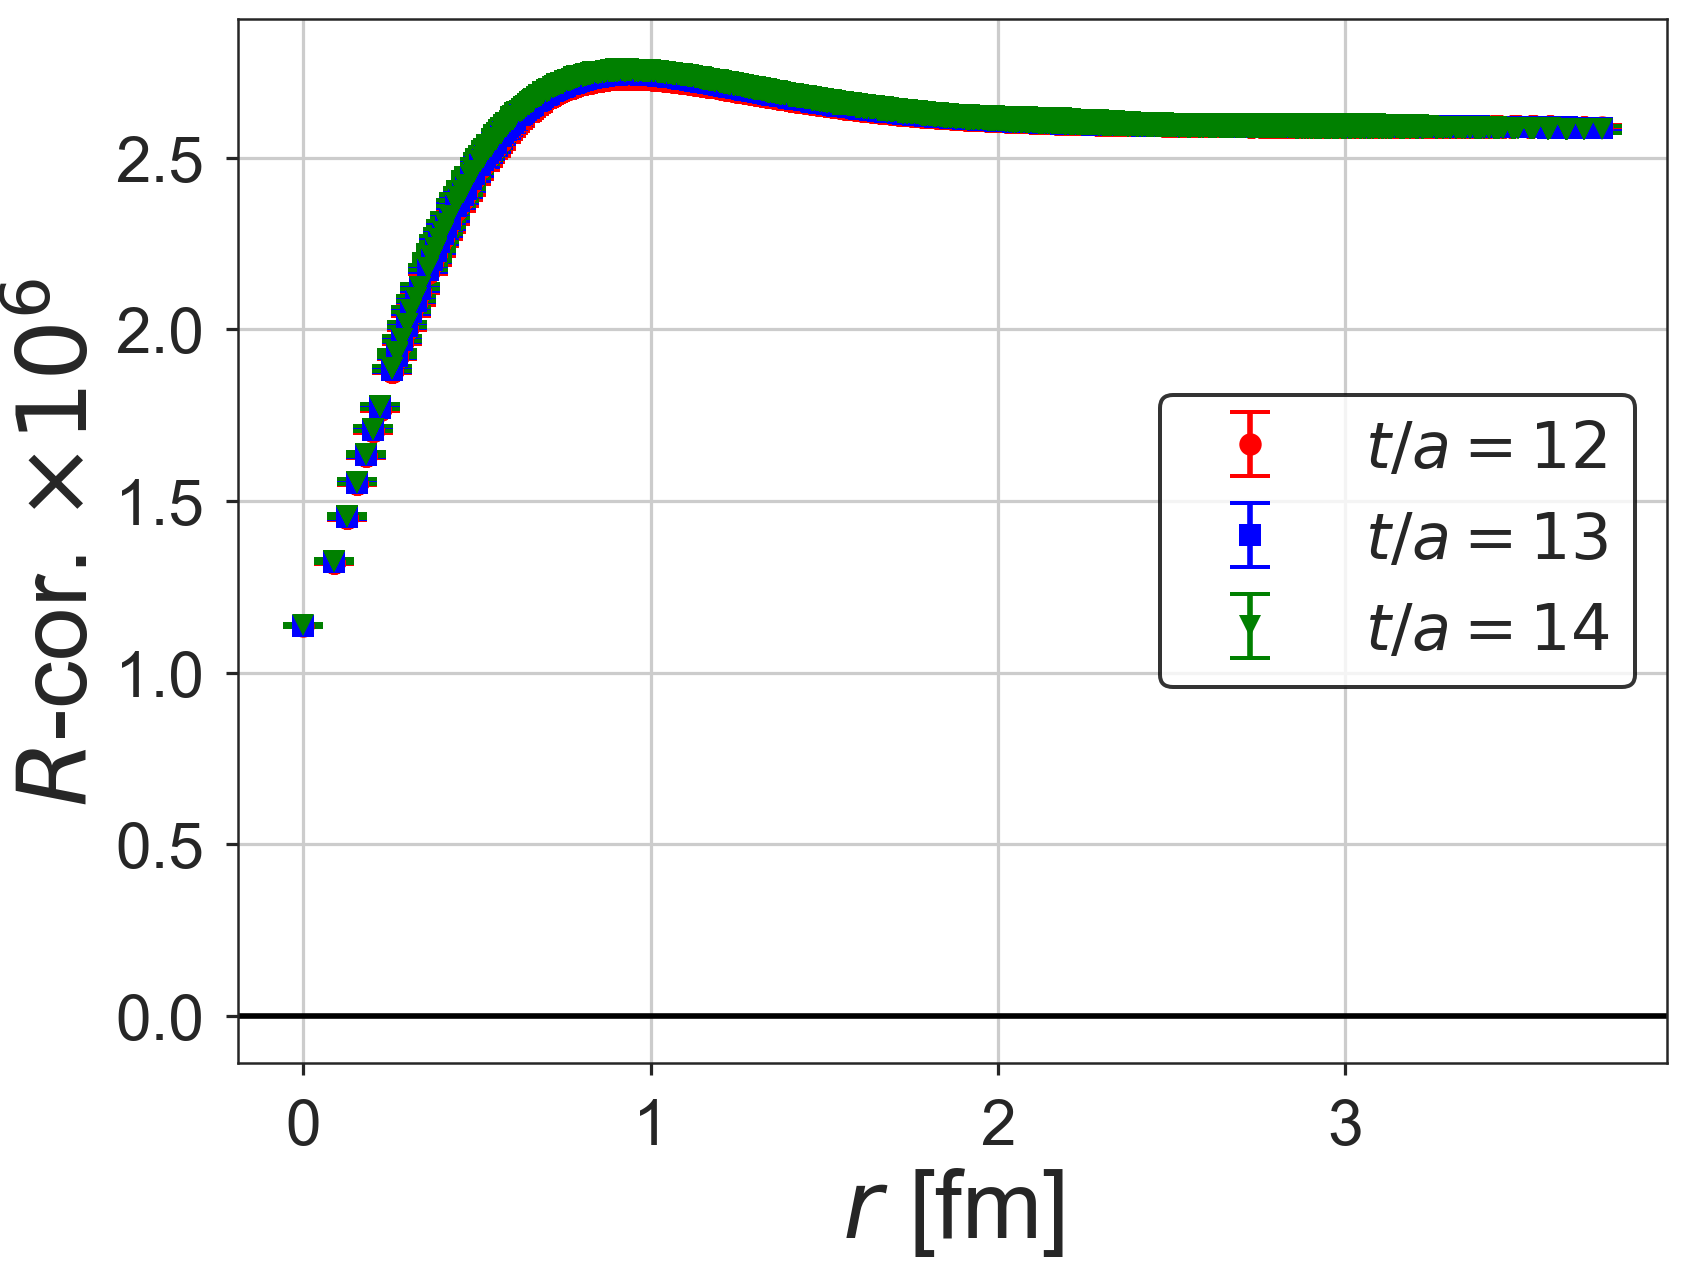

In [14]:
fig, ax = plt.subplots()
fac = 1e6
for it, c, fmt in zip(its, ['red', 'blue', 'green'],
                      ['o', 's', 'v']):
    ax.errorbar(rs.flatten()*lat_unit, Rcorr_jk[it].mean(axis=0).flatten()*fac,
             Rcorr_jk[it].std(axis=0).flatten() * np.sqrt(bin_num - 1)*fac, 
                color=c,  capsize=10, capthick=2, fmt=fmt,
               label=rf'$t/a = {it}$')
    
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$R$-cor. $\times 10^{:d}$'.format(int(np.log10(fac))), size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')

# potential

\begin{equation}
V(r) = - \frac{H_0 R}{R} - \frac{(\partial/\partial t)R}{R}
+ \frac{1}{4m_B} \frac{(\partial/\partial t)^2 R}{R}
\end{equation}
Hamiltonian  $H_0 = - \frac{\nabla^2}{m_B}$

In [15]:
# \nabla^2 operator
lap = lambda vec: - 6.0 * vec + ( np.roll(vec,+1,0) + np.roll(vec,-1,0)
                                + np.roll(vec,+1,1) + np.roll(vec,-1,1)
                                + np.roll(vec,+1,2) + np.roll(vec,-1,2))

it0  = 13
pot_jk = {}
pot_jk['lap'] = np.array([lap(Rcorr_jk[it0][ibin,:,:,:])/(mxi*Rcorr_jk[it0][ibin,:,:,:])
                          for ibin in range(bin_num)])

pot_jk['dt']  = np.array([ - (Rcorr_jk[it0+1][ibin,:,:,:] - Rcorr_jk[it0-1][ibin,:,:,:])
                          / (2 * Rcorr_jk[it0][ibin,:,:,:]) for ibin in range(bin_num)])

pot_jk['dt2'] = np.array([(Rcorr_jk[it0+1][ibin,:,:,:] - 2 * Rcorr_jk[it0][ibin,:,:,:]
                           + Rcorr_jk[it0-1][ibin,:,:,:])
                          / (4 * mxi * Rcorr_jk[it0][ibin,:,:,:]) for ibin in range(bin_num)])

pot_jk['tot'] = pot_jk['lap'] + pot_jk['dt'] + pot_jk['dt2']

In [16]:
a1_uniq = np.array([ix + L * (iy + L * iz)
                   for ix in range(0, L//2+1)
                   for iy in range(0, ix+1)
                   for iz in range(0, iy+1)])

In [17]:
# reduce redundant points
pot_jk_a1 = {}
for key in pot_jk.keys():
    pot_jk_a1[key] = pot_jk[key].reshape(bin_num, L**3)[:,a1_uniq]

rs_a1  = rs.flatten()[a1_uniq]

plot potential

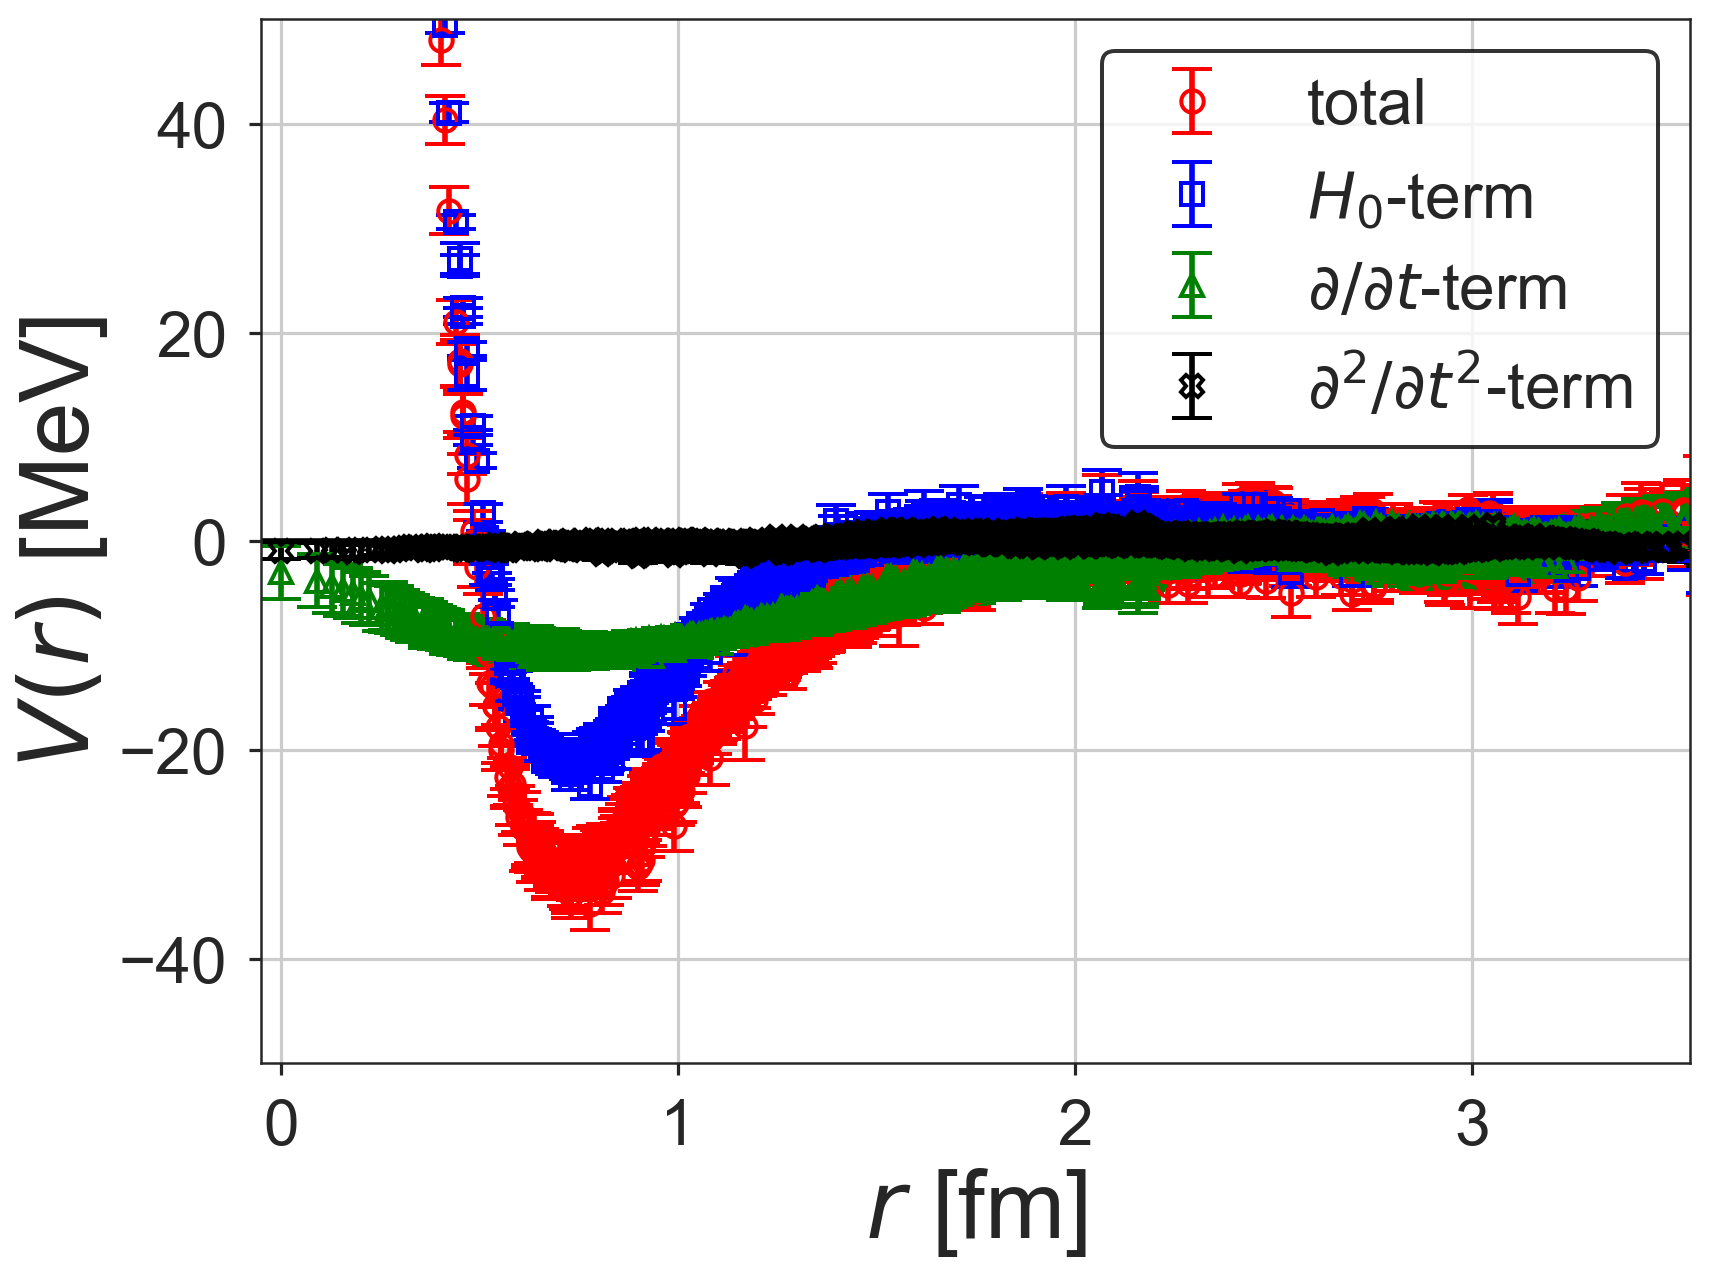

In [18]:
fig, ax = plt.subplots()
ax.errorbar(rs_a1*lat_unit, pot_jk_a1['tot'].mean(axis=0)*ainv,
           pot_jk_a1['tot'].std(axis=0)*np.sqrt(bin_num - 1)*ainv,
           fmt='o', color='red', mfc='none', mew=2.0, capsize=10, capthick=2.0, label='total')

ax.errorbar(rs_a1*lat_unit, pot_jk_a1['lap'].mean(axis=0)*ainv,
           pot_jk_a1['lap'].std(axis=0)*np.sqrt(bin_num - 1)*ainv,
           fmt='s', color='blue', mfc='none', mew=2.0, capsize=10, capthick=2.0, label=r'$H_0$-term')

ax.errorbar(rs_a1*lat_unit, pot_jk_a1['dt'].mean(axis=0)*ainv,
           pot_jk_a1['dt'].std(axis=0)*np.sqrt(bin_num - 1)*ainv,
           fmt='^', color='green', mfc='none', mew=2.0, capsize=10, capthick=2.0, label=r'$\partial/\partial t$-term')

ax.errorbar(rs_a1*lat_unit, pot_jk_a1['dt2'].mean(axis=0)*ainv,
           pot_jk_a1['dt2'].std(axis=0)*np.sqrt(bin_num - 1)*ainv,
           fmt='X', color='black', mfc='none', mew=2.0, capsize=10, capthick=2.0, label=r'$\partial^2/\partial t^2$-term')

ax.axhline(0, color='black')
ax.set_ylim(-50, 50)
ax.set_xlim(-0.05, 3.55)
ax.set_ylabel(r'$V(r)$ [MeV]', size=48)
ax.set_xlabel(r'$r$ [fm]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

# eigenfunction of the finite volume hamiltonian

We consider the eigenfunction of the finite volume Hamiltonian, which is given by
\begin{equation}
H \equiv H_0 + V
\end{equation}
using the HAL QCD potential $V(r)$.

In [19]:
# solve eigenvalue problem using scipy.sparse.linalg
Vol = L**3
ibin =  0
Nev = 5 # number of low-lying 
pot = pot_jk['tot'][ibin,:,:,:]
H = LinearOperator((Vol, Vol),
                  matvec=lambda vec: pot.flatten() * vec
                    - lap(vec.reshape(L,L,L)).flatten()/mxi, dtype='float64')

vals, vecs  = scipy.sparse.linalg.eigsh(H,  which='SA', k=Nev)

In [20]:
# extract A1 component of the wavefunction
def A1_projection(wave_in):
    Ns = round(len(wave_in)**(1/3))
    wave = wave_in.reshape(Ns,Ns,Ns)
    wave_tmp1 = (wave[:,:,:] + np.roll(wave,-1,0)[::-1,:,:]
                + np.roll(wave,-1,1)[:,::-1,:]
                + np.roll(wave,-1,2)[:,:,::-1]
                + np.roll(np.roll(wave,-1,0),-1,1)[::-1,::-1,:]
                + np.roll(np.roll(wave,-1,1),-1,2)[:,::-1,::-1]
                + np.roll(np.roll(wave,-1,2),-1,0)[::-1,:,::-1]
                + np.roll(np.roll(np.roll(wave,-1,0),-1,1),-1,2)[::-1,::-1,::-1])/8.0
    wave_tmp2 = (wave_tmp1 
                + np.swapaxes(wave_tmp1,0,1)
                + np.swapaxes(wave_tmp1,1,2)
                + np.swapaxes(wave_tmp1,2,0)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,1),1,2)
                + np.swapaxes(np.swapaxes(wave_tmp1,0,2),2,1))/6.0e0

    return wave_tmp2.flatten()


In [21]:
# check eigenfunction and its A1 norm
print('# level   eigenval   A1norm')
for nth, val in enumerate(vals):
    vecs[:,nth] *= np.sign(vecs[0,nth]) # psi(0) > 0 positive
    a1proj = A1_projection(vecs[:,nth])
    a1norm  = np.dot(a1proj, a1proj)
    print(f'{nth}        {val*ainv:3.2f} [MeV] {a1norm:2.1f}')

# level   eigenval   A1norm
0        -2.86 [MeV] 1.0
1        52.62 [MeV] 1.0
2        53.10 [MeV] 0.0
3        53.10 [MeV] 0.0
4        53.10 [MeV] 0.0


The lowest and 1st excited states are A1 wavefunction.

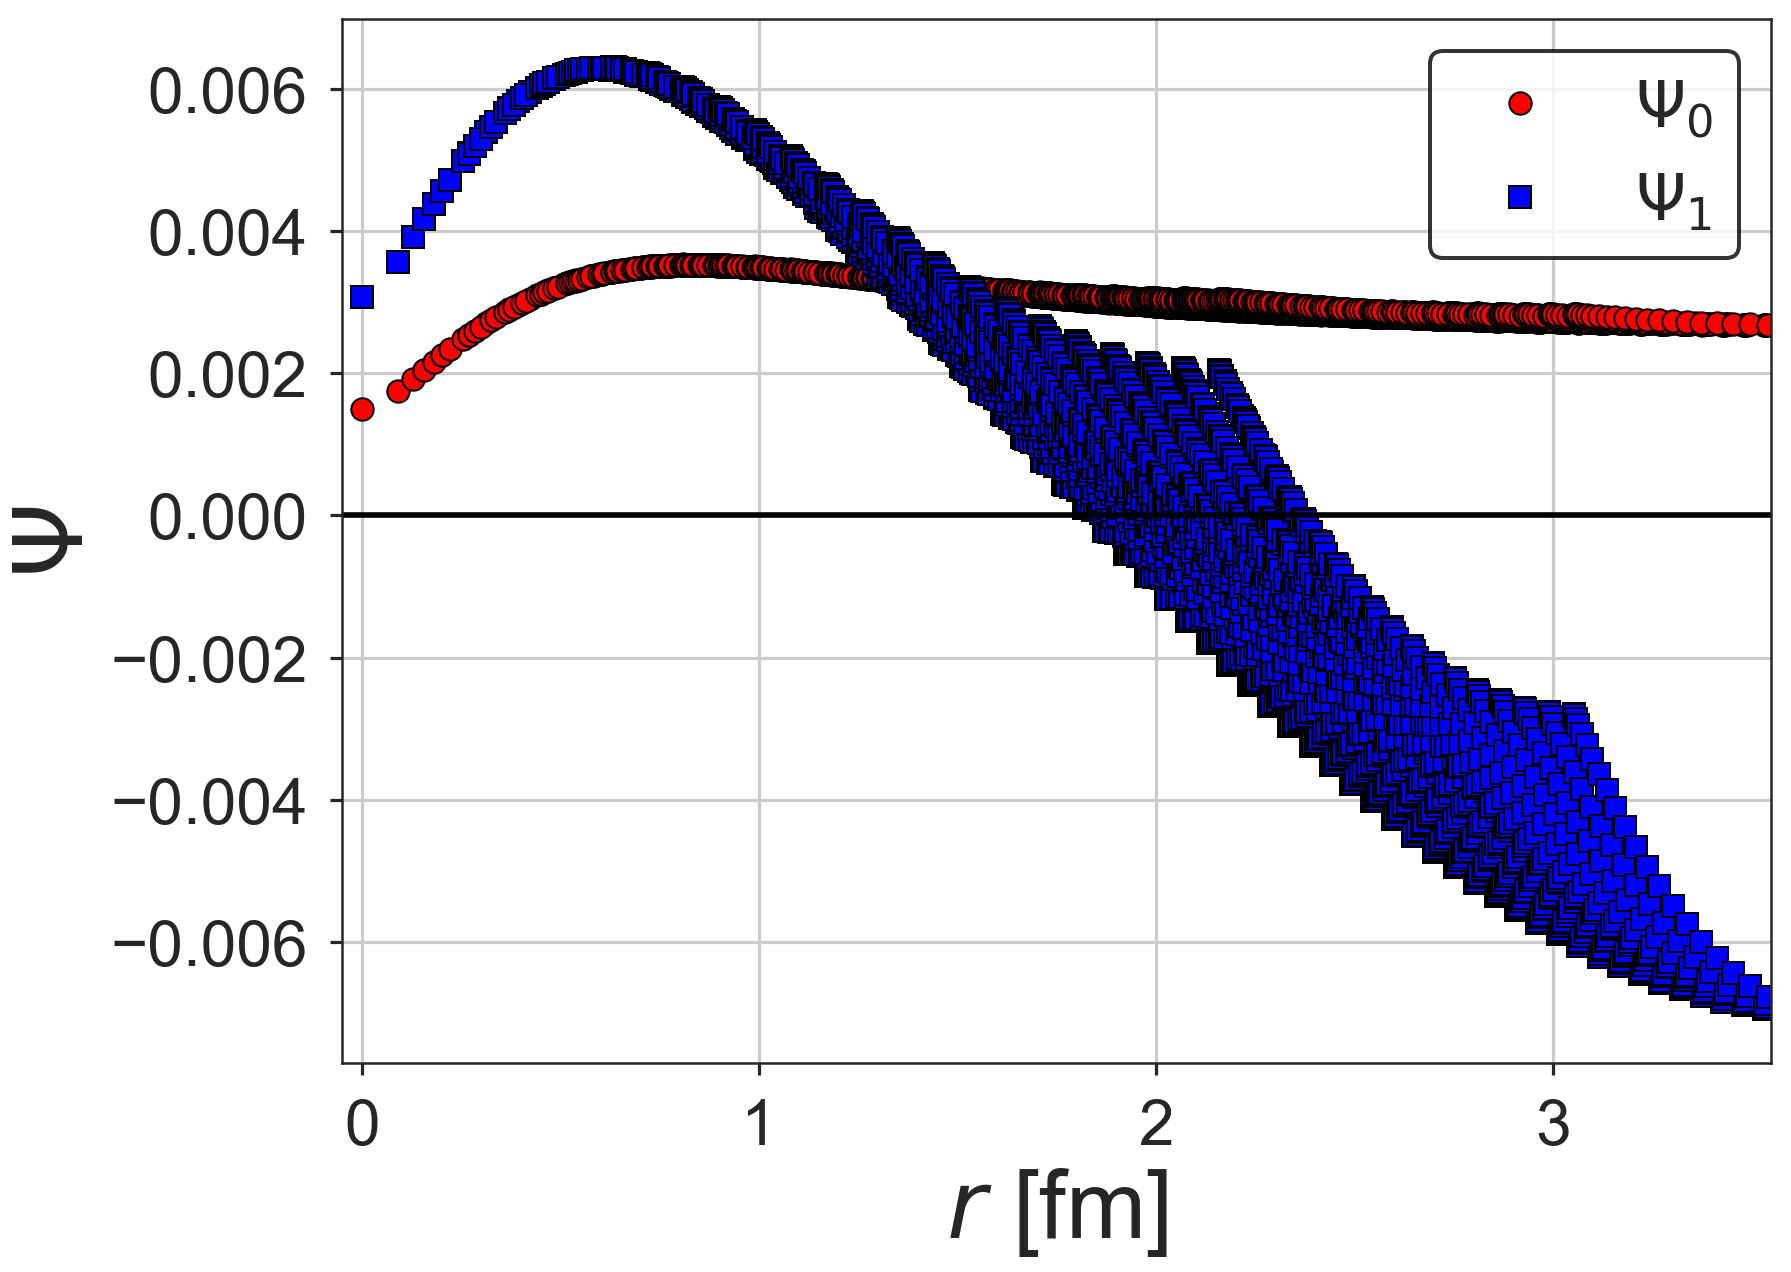

In [22]:
fig, ax = plt.subplots()
ax.plot(rs_a1*lat_unit, vecs[a1_uniq,0], 'ro', label=r'$\Psi_0$',
       mec='black',  mew=1)
ax.plot(rs_a1*lat_unit, vecs[a1_uniq,1], 'bs', label=r'$\Psi_1$',
       mec='black', mew=1)

leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

ax.set_xlim(-0.05, 3.55)
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$\Psi$', size=48)
ax.axhline(0, color='black')